In [1]:
# 使用pandas读取数据
import pandas as pd


data_path = "./data/adult.data"
raw_data = pd.read_csv(data_path)
## 选取需要使用的列
cols = ["age", "education_num",
        "capital_gain", "capital_loss", "hours_per_week", "label"]
data = raw_data[cols]

In [2]:
import matplotlib
print(matplotlib.__file__)

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py


In [4]:
# 将label转换为可以运算的变量
data.loc[:, "label_code"] = pd.Categorical(data.label).codes
data.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code
0,39,13,2174,0,40,<=50K,0
1,50,13,0,0,13,<=50K,0
2,38,9,0,0,40,<=50K,0
3,53,7,0,0,40,<=50K,0
4,28,13,0,0,40,<=50K,0


In [5]:
# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=2310)

In [6]:
import scipy.stats as scs


# 调试代码用的数据
tmp_data = [["<=50K", 10], ["<=50K", 11], ["<=50K", 15], [" >50K", 12], [" >50K", 13]] 
tmp_df = pd.DataFrame(tmp_data, columns = ['label', 'hours'])
tmp_df.head()

,label,hours
0,<=50K,10
1,<=50K,11
2,<=50K,15
3,>50K,12
4,>50K,13


In [7]:
# 将hours划分成类别变量
tmp_cat = pd.cut(tmp_df["hours"], [10, 11, 15], include_lowest=True)
tmp_cat

0    (9.999, 11.0]
1    (9.999, 11.0]
2     (11.0, 15.0]
3     (11.0, 15.0]
4     (11.0, 15.0]
Name: hours, dtype: category
Categories (2, interval[float64]): [(9.999, 11.0] < (11.0, 15.0]]

In [8]:
# 计算列联表
tmp_cross = pd.crosstab(tmp_df["label"], tmp_cat)
tmp_cross.head()

hours,"(9.999, 11.0]","(11.0, 15.0]"
label,,
>50K,0,2
<=50K,2,1


In [9]:
# 卡方统计量
scs.chi2_contingency(tmp_cross)

(0.31250000000000006, 0.5761501220305787, 1, array([[0.8, 1.2],
        [1.2, 1.8]]))

In [10]:
def divide_data(data, min_value, max_value):
    """
    遍历所有可能的分段，返回卡方统计量最高的分段
    """
    max_chi2 = 0
    index = -1
    max_p_value = 0
    for i in range(min_value + 1, max_value):
        category = pd.cut(data["hours_per_week"], [min_value, i, max_value],
                          include_lowest=True)
        cross = pd.crosstab(data["label"], category)
        chi2, p_value, _, _ = scs.chi2_contingency(cross)
        if chi2 > max_chi2:
            max_p_value = p_value
            max_chi2 = chi2
            index = i
    return max_p_value, max_chi2, index


def do_divide(data, interval):
    """
    使用贪心算法，得到“最优”的分段
    """
    category = []
    p_value, chi2, index = divide_data(data, interval[0], interval[1])
    if chi2 < 15:
        category.append(interval)
    else:
        category += do_divide(data, [interval[0], index])
        category += do_divide(data, [index, interval[1]])
    return category


def get_category(data):
    """
    基于卡方检验，得到每星期工作时间的“最优”分段
    """
    interval = [data["hours_per_week"].min(), data["hours_per_week"].max()]
    _category = do_divide(data, interval)
    s = set()
    for i in _category:
        s = s.union(set(i))
    category = list(s)
    category.sort()
    return category

In [11]:
# 如果想将hours_per_week等分成10份则
# category = range(0, 105, 10)
category = get_category(train_set)
print(category)
labels = ["{0}-{1}".format(category[i], category[i+1]) for i in range(len(category) - 1)]
print(labels)

[1, 34, 37, 41, 49, 99]
['1-34', '34-37', '37-41', '41-49', '49-99']


In [13]:
train_set.loc[:, "hours_per_week_group"] = pd.cut(train_set["hours_per_week"],
                                           category, include_lowest=True, labels=labels)
test_set.loc[:, "hours_per_week_group"] = pd.cut(test_set["hours_per_week"],
                                           category, include_lowest=True, labels=labels)
train_set.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code,hours_per_week_group
24654,36,10,0,0,40,>50K,1,37-41
16793,50,7,0,0,40,<=50K,0,37-41
16519,26,13,0,0,40,<=50K,0,37-41
17001,43,10,3103,0,40,>50K,1,37-41
23618,41,14,0,0,40,>50K,1,37-41


In [14]:
# 训练模型
import statsmodels.api as sm


c_formula = "label_code ~ education_num + capital_gain + capital_loss + C(hours_per_week_group)"
c_model = sm.Logit.from_formula(c_formula, data=train_set)
c_model = c_model.fit()

Optimization terminated successfully.
         Current function value: 0.419160
         Iterations 8


In [15]:
b_formula = "label_code ~ education_num + capital_gain + capital_loss + hours_per_week"
b_model = sm.Logit.from_formula(b_formula, data=train_set)
b_model = b_model.fit()

Optimization terminated successfully.
         Current function value: 0.426128
         Iterations 8


In [16]:
print(c_model.summary())

                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26040
Method:                           MLE   Df Model:                            7
Date:                Mon, 08 Jul 2019   Pseudo R-squ.:                  0.2402
Time:                        00:20:24   Log-Likelihood:                -10918.
converged:                       True   LL-Null:                       -14370.
                                        LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.1007      0.107    -57.082      0.000      -6.310      -5.891
C(hours_per_week_group)[T.34-37]     0.7750      0.109      7.138

In [18]:
# 得到预测结果
test_set.loc[:, "b_prob"] = b_model.predict(test_set)
test_set.loc[:, "c_prob"] = c_model.predict(test_set)
test_set.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code,hours_per_week_group,b_prob,c_prob
19463,55,9,0,0,40,<=50K,0,37-41,0.113848,0.116607
24430,38,10,0,0,40,<=50K,0,37-41,0.150374,0.152748
19621,36,11,0,0,60,<=50K,0,49-99,0.343604,0.336763
3862,41,11,0,1848,48,>50K,1,41-49,0.576574,0.623599
27549,20,10,0,0,40,<=50K,0,37-41,0.150374,0.152748


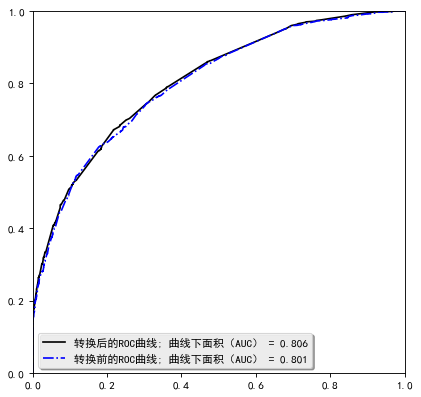

In [19]:
# ROC曲线
from sklearn import metrics
import matplotlib.pyplot as plt


# 计算b_model的预测效果
b_fpr, b_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["b_prob"])
b_auc = metrics.auc(b_fpr, b_tpr)
# 计算c_model的预测效果
c_fpr, c_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["c_prob"])
c_auc = metrics.auc(c_fpr, c_tpr)
# 画图
fig = plt.figure(figsize=(6, 6), dpi=80)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
ax.plot(c_fpr, c_tpr, "k",
        label="%s; %s = %0.3f" % ("转换后的ROC曲线", "曲线下面积（AUC）", c_auc))
ax.plot(b_fpr, b_tpr, "b-.",
        label="%s; %s = %0.3f" % ("转换前的ROC曲线", "曲线下面积（AUC）", b_auc))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
legend = plt.legend(shadow=True)
plt.show()